In [232]:
# General
import pickle
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats
import itertools
from pandas.plotting import register_matplotlib_converters
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer, make_column_selector

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import trange

# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
warnings.filterwarnings('ignore')

In [337]:
# Load data, sort on zip and date and set index to datetime
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f: df = pickle.load(f)
df.sort_values(['census_cbsa_geoid', 'census_zcta5_geoid', 'date'], inplace = True)

In [334]:
df.columns

Index(['date', 'census_zcta5_geoid', 'sfr_rental_delta', 'sfr_price_delta',
       'mfr_rent_delta', 'mfr_occ_delta', 'cos_month', 'sin_month'],
      dtype='object')

In [338]:
# subset for time frame that includes MFR data (Jan 2015 - June 2023)
df = df.loc[(df.date >= '2015-01-01') & (df.date <= '2023-06-01')]

In [339]:
# drop incomplete zips
drops = df.loc[df.mfr_occ.isna()].census_zcta5_geoid.unique().tolist()
df.drop(df.loc[df['census_zcta5_geoid'].isin(drops)].index, inplace=True)

In [341]:
# Translate all index columns into delta
df['offset_price_index'] = df['sfr_price_index'].shift(periods = 1)
df.dropna(inplace=True)
df['sfr_price_delta'] = df['sfr_price_index'] - df['offset_price_index']

df['offset_mfrrent_index'] = df['mfr_mean_rent_index'].shift(periods = 1)
df.dropna(inplace=True)
df['mfr_rent_delta'] = df['mfr_mean_rent_index'] - df['offset_mfrrent_index']

df['offset_mfrocc_index'] = df['mfr_mean_occ_index'].shift(periods = 1)
df.dropna(inplace=True)
df['mfr_occ_delta'] = df['mfr_mean_occ_index'] - df['offset_mfrocc_index']

In [342]:
# Keep only desired columns
df = df[['date', 'census_zcta5_geoid', 'sfr_rental_delta', 'sfr_price_delta', 
         'mfr_rent_delta', 'mfr_occ_delta', 'cos_month', 'sin_month']]
df

,date,census_zcta5_geoid,sfr_rental_delta,sfr_price_delta,mfr_rent_delta,mfr_occ_delta,cos_month,sin_month
109,2019-02-01,30002,0.5569,0.2339,0.4898,0.0323,0.5000,0.8660
110,2019-03-01,30002,0.6948,1.3213,1.2114,-0.1921,0.0000,1.0000
111,2019-04-01,30002,0.8489,0.2247,0.5009,-0.4165,-0.5000,0.8660
112,2019-05-01,30002,0.6759,0.6222,0.5009,-0.2884,-0.8660,0.5000
113,2019-06-01,30002,0.5433,0.9363,0.5140,-0.6174,-1.0000,0.0000
...,...,...,...,...,...,...,...,...
36073,2023-02-01,44333,0.8291,-1.3466,1.7447,0.0000,0.5000,0.8660
36074,2023-03-01,44333,0.6817,0.1833,0.8363,-0.2888,0.0000,1.0000
36075,2023-04-01,44333,0.9218,1.0300,0.2950,0.0000,-0.5000,0.8660
36076,2023-05-01,44333,1.3360,1.8028,-0.0658,-0.2865,-0.8660,0.5000


In [360]:
# Define class

class SFR_DATASET(Dataset):
    def __init__(self, df):
        self.data = df.to_dict('records') # random access is easier with dictionaries
    
    def __len__(self): 
        return len(self.data)-24  # subtract length of input + output
    
    def __getitem__(self, idx): 
        # given an index, get three months as input
        # next six months as output
        
        #input = pd.DataFrame(self.data[idx:idx+3])
        #output = pd.DataFrame(self.data[idx+4:idx+10])
        print(idx)
        
        input = pd.DataFrame(self.data[idx:idx+3])
        output = pd.DataFrame(self.data[idx+4:idx+10])
        
        # each of these are 3x1 tensors (3 months of data)
        in_sfr = torch.tensor(input['sfr_rental_delta']) 
        in_sfp = torch.tensor(input['sfr_price_delta'])
        in_mfr = torch.tensor(input['mfr_rent_delta'])
        in_mfo = torch.tensor(input['mfr_occ_delta'])
        in_sinm = torch.tensor(input['sin_month'])
        in_cosm = torch.tensor(input['cos_month']) 
        x = torch.cat((in_sfr, in_sfp, in_mfr, in_mfo, in_sinm, in_cosm), dim = 0) # concat into 18-wide vector
        y = torch.tensor(output['sfr_rental_delta'])
        return {'X':x.float(), 'Y':y.float()}

In [348]:
# Define scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

col_transform = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(feature_range=(-1, 1)), make_column_selector(dtype_include=np.number))], 
        remainder='passthrough',
        verbose_feature_names_out = False
)

In [361]:
# Create zip dict to store class for each zip
zip_dict_train = {}
zip_dict_test = {}

# Cast the class, separating out by zipcdoe
for zipcode in df['census_zcta5_geoid'].unique():
    
    # Filter for single zipcode
    zipcode_df = df[df['census_zcta5_geoid'] == zipcode]
    
    # Train test split
    tss = TimeSeriesSplit(n_splits = 2, test_size = 6) # hold out 6 months as test set
    for train_index, test_index in tss.split(zipcode_df):
        df_train, df_test = zipcode_df.iloc[train_index, :], zipcode_df.iloc[test_index,:]
    
    # Transform training data, cast class and store
    train_X = col_transform.fit_transform(df_train)
    train_X = pd.DataFrame(train_X, columns = col_transform.get_feature_names_out())
    train_sfr = SFR_DATASET(train_X)
    zip_dict_train[zipcode] = train_sfr
    
    # Transform testing data, cast class and store
    test_X = col_transform.fit_transform(df_test)
    test_X = pd.DataFrame(test_X, columns = col_transform.get_feature_names_out())
    test_sfr = SFR_DATASET(test_X)
    zip_dict_test[zipcode] = test_sfr

In [346]:
# check contents of dict
print(zip_dict_train['30002'].__len__())
print(zip_dict_train['30002'].__getitem__(0))

print(zip_dict_test['30002'].__len__())
print(zip_dict_test['30002'].__getitem__(0))

# for given index
# returns X as 1x18 vector (3 months for each of the 6 input variables)
# returns y as 1x6 vecotr (6 month prediction for sfr_rental)

47
{'X': tensor([-5.9914e-01, -4.9856e-01, -3.8609e-01, -3.2488e-01,  2.5762e-01,
        -3.2986e-01, -2.9385e-01, -2.0646e-01, -2.9249e-01,  3.0867e-02,
        -1.5630e-01, -3.4346e-01,  8.6603e-01,  1.0000e+00,  8.6603e-01,
         5.0000e-01,  6.1232e-17, -5.0000e-01]), 'Y': tensor([-0.6090, -0.5183, -0.6592, -0.6600, -0.7521, -0.8608])}
6
{'X': tensor([ 5.3144e-01,  1.0000e+00,  5.1913e-01, -1.0000e+00, -7.2259e-01,
         2.4968e-01, -1.0000e+00,  7.7828e-01,  2.2030e-01, -1.0000e+00,
        -1.2212e-01,  7.1187e-01, -2.2204e-16,  7.3205e-01,  1.0000e+00,
         1.0000e+00,  6.0770e-01,  7.1797e-02]), 'Y': tensor([ 0.1899, -1.0000])}


In [357]:
sfr[4]['X'].size()

4


torch.Size([18])

In [350]:
# Model: simple multilayer perceptron
# sequential 3 layer model

# want hidden dim between input and output for what we're doing or it can be less
# maximum number of free vars that actually alter anything

class SFR_MODEL(nn.Module):
    def __init__(self, indim, hdim, outdim):
        super().__init__() # for nn.MOdule you must initialize the super class
        self.layers = nn.Sequential(
            nn.Linear(indim, hdim),
            nn.LeakyReLU(),
            nn.Linear(hdim, outdim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.layers(x)

In [351]:
# create instance of model

# indim matches length of input vector
# outdim matches length of output vector
# hdim?
model = SFR_MODEL(indim = 18, hdim = 12, outdim = 6)
print(model)

SFR_MODEL(
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): Tanh()
  )
)


In [352]:
# set up training loop
# optimizer - Adam good to start with
# datalaoder - wrap around dataset to shuffle through batches

opt = Adam(model.parameters()) # this is minimum (telling Adam all the numbers it can vary)
batchsize = 3
epochs = 150 # go though data 3x
loss_fn = nn.MSELoss()

In [362]:
# Training loop

losses_dict = {} # initialize dict to store loss values for each zip

for zipcode in df['census_zcta5_geoid'].unique():
    
    # Access one zipcdode
    sfr = zip_dict_train[zipcode]
    
    # create dataloader
    dl = DataLoader(sfr, batch_size = batchsize, shuffle = True, drop_last = True)
    
    # initialize list for zip-level losses
    losses = []
    
    for epoch in trange(epochs):
        for batch in dl:
            
            opt.zero_grad() # at the beginning of batch, zero out the optimizer
        
            # use inputs and outputs to make model prediction
            x = batch['X']
            y = batch['Y']
            y_hat = model(x)
        
            loss = loss_fn(y_hat, y) # calculate loss
            loss.backward() # calculate gradient of loss
            opt.step() # runs the optimizer and updates model params based on gradient
            losses.append(loss.cpu().detach().numpy()) # single value as a numpy
            
    losses_dict[zipcode] = losses

  1%|▎                                                   | 1/150 [00:00<00:16,  9.04it/s]

20
7
13
22
6
9
2
19
5
3
8
21
16
18
15
10
0
11
14
12
1
0
17
10
3
5
14
15
13
2
20
12
11
16
18
8
22
7
9
21
1
6
0
9
22


  2%|█                                                   | 3/150 [00:00<00:13, 10.84it/s]

17
8
16
19
21
14
10
5
4
6
3
12
13
20
11
18
7
1
4
22
7
20
0
19
12
1
3
9
11
17
21
5
16
8
10
18
15
2
13
7


  3%|█▋                                                  | 5/150 [00:00<00:18,  7.71it/s]

13
20
3
0
17
15
11
22
8
18
19
14
9
1
2
4
5
10
6
12
3
7


  4%|██                                                  | 6/150 [00:00<00:17,  8.07it/s]

15
11
6
14
5
20
9
10
2
17
22
12
1
16
8
4
13
19
21
11
8
10
15
0
13
9
7
14
5
6
16
1
4
19
20
17
22
21
12
2
15
17
5
20
1
6
21
13
19
9
11
18
16
12
0
14
4
3
7
22


  5%|██▊                                                 | 8/150 [00:00<00:14,  9.50it/s]

2
12
20
6
11
19
2
14
15
0
1
18
13
9
5
16
4
7
8
17
10
21
8
6
0
1
9
19
11
10
5
21
15
3
4
22
2
16
17
7
12
18


  7%|███▋                                               | 11/150 [00:01<00:24,  5.79it/s]

20
4
2
14
15
8
13
17
19
21
16
18
1
20
11
6
0
10
12
9
7
3
1
3
11
10
9
8
4
21
14
19
18
16


  9%|████▊                                              | 14/150 [00:01<00:16,  8.39it/s]

5
6
2
20
17
15
22
7
13
11
18
5
7
21
20
2
8
17
6
0
14
9
19
22
10
13
1
16
4
15
17
18
0
14
20
6
21
1
19
7
10
12
5
2
11
15
3
4
13
9
8
2
7
5
15
11
19
18
13
20
22
4
1


 11%|█████▍                                             | 16/150 [00:02<00:13,  9.61it/s]

10
12
0
6
17
14
16
3
9
17
7
3
12
0
6
13
1
4
14
19
16
15
21
18
11
5
2
10
9
20
10
9
3
20
12
7
14
1
11
21
4
2
16
19
8
17
22
15
6
0
13
18
2
16
4
17
20
22
12
10
5
7


 12%|██████                                             | 18/150 [00:02<00:13,  9.49it/s]

3
11
0
21
1
15
6
13
14
8
3
20
14
6
21
0
5
8
16
1
15
7
11
19
9
12
4
2
13
17
10
7
16
8
3
13
18
11
6
2
20
10
9
14
15
17
22
5
4
19
0
12


 13%|██████▊                                            | 20/150 [00:02<00:16,  7.73it/s]

19
1
6
0
11
20
5
22
16
2
21
3
18
10
8
4
15
13
17
7
9
14
5
11
20
22
2
4
6
12
13
15
19
9
7
10
17
3
18
1
8


 15%|███████▍                                           | 22/150 [00:02<00:17,  7.46it/s]

0
9
15
5
13
22
1
2


 15%|███████▊                                           | 23/150 [00:03<00:18,  6.82it/s]

0
21
20
6
14
3
17
4
11
18
7
19
16
8
3
11
13
7
0
20
2
19
1
14
15
18
12
4
5
6
10
16
8
22
21


 17%|████████▌                                          | 25/150 [00:03<00:17,  7.26it/s]

12
0
21
11
17
10
1
14
19
2
6
8
15
7
4
5
13
9
22
3
16
19
17
6
7
16
4
9
3
1
21
10
2
18
12
11
14
5
8
15
20
22
5
18
21
3
22
12
7
11
20
14
2
1


 19%|█████████▌                                         | 28/150 [00:03<00:14,  8.17it/s]

6
13
9
4
10
0
16
19
15
21
19
7
2
3
16
13
18
0
8
20
15
17
14
12
1
6
9
11
22
5
16
7
12
18


 19%|█████████▊                                         | 29/150 [00:03<00:15,  7.61it/s]

1
15
11
6
3
20
14
10
4
19
22
17
5
2
0
9
21
13
12
16
17
4
18
11
1
5
9
14
19
6
21
8
0
15
10
22
3
2
13
7
11
1
0
18
4
8
15
17
5
19
10
12
22
21
9


 22%|███████████▏                                       | 33/150 [00:04<00:10, 10.89it/s]

16
6
20
2
22
8
12
4
16
10
2
9
21
1
13
15
18
0
6
20
14
3
5
11
19
0
3
2
8
14
6
1
4
7
18
16
10
12
9
22
5
11
20
13
21
17
18
5
15
6
8
2
13
19
17
3
22
11
10
4
12
16
0
1
21
9
14
8
6
22
4
16
1
20
3
19
10
0
5
13
11
18
14
21


 23%|███████████▉                                       | 35/150 [00:04<00:17,  6.54it/s]

17
7
9
2
11
17
12
7
1
19
3
0
22
9


 24%|████████████▏                                      | 36/150 [00:04<00:21,  5.25it/s]

20
14
16
2
18
21
6
4
13
8
5
18
0
14
15
1


 26%|█████████████▎                                     | 39/150 [00:05<00:14,  7.64it/s]

8
6
4
16
12
13
9
22
11
7
3
5
2
17
19
20
10
3
20
16
12
1
14
8
11
15
2
6
18
9
0
22
17
21
4
19
5
19
18
6
14
3
13
16
1
9
20
22
12
0
2
8
21
5
4
11
10
15


 27%|█████████████▉                                     | 41/150 [00:05<00:11,  9.58it/s]

20
13
19
14
22
0
1
6
12
7
11
18
8
3
5
16
2
21
4
10
9
10
18
22
9
6
5
15
16
21
17
4
19
0
2
13
3
11
12
20
14
1
17
5
7
6
21
22
20
0
14
1
8
9
16
3
19
13
4
2
15
10
11
14
21
5
6
18
1
4
22
17


 29%|██████████████▌                                    | 43/150 [00:05<00:09, 10.79it/s]

7
0
9
10
19
16
11
12
8
2
13
3
12
11
19
7
13
21
4
17
16
20
3
1
14
5
0
2
10
22
18
6
15
15
7
20
18
3
4
13
21
10
6
16
22
19
11
14
12
8
17
2
0


 30%|███████████████▎                                   | 45/150 [00:05<00:10, 10.49it/s]

1
17
13
0
21
20
22
2
14
7
4
5
6
1
9
12
11
16
8
19
18
10
21
5
16
17
18
2
12
14
11
8


 31%|███████████████▉                                   | 47/150 [00:05<00:11,  9.22it/s]

1
10
19
3
4
20
13
15
0
22
9
5
3
14
7
21
18
10
15
22
16
19
11
6
1
0
20
8
2
9
17
13
3
6
9
11
7
14
19
0
15
21
20
4


 33%|████████████████▋                                  | 49/150 [00:06<00:15,  6.61it/s]

1
16
18
13
12
8
22
2
17
12
3
11
15
21
22
17
8
18
4
13
2
20
1
6


 34%|█████████████████▎                                 | 51/150 [00:06<00:13,  7.11it/s]

0
19
10
5
16
7
6
22
0
4
17
3
18
8
16
1
2
20
21
14
15
9
7
19
12
11
10
1
6
18
21
0
5
17
4
15
8
13
3
19
10
11
20
7


 35%|██████████████████                                 | 53/150 [00:06<00:12,  8.03it/s]

9
14
16
12
12
10
6
19
11
14
17
8
22
5
2
21
15
4
16
13
0
18
20
1
7
20
17
6
5
14
16
18
12
4
19
8
9
11
0
10
15
1
13
2
22
3


 37%|██████████████████▋                                | 55/150 [00:07<00:16,  5.90it/s]

14
22
20
17
19
12
5
8
4
2
13
21
1
9
0
11
10
18
3
15
16
11
4
2
18
19


 37%|███████████████████                                | 56/150 [00:07<00:17,  5.28it/s]

14
8
12
17
20
21
16
6
7
22
0
13
5
15
10
9
4
15
7
21


 38%|███████████████████▍                               | 57/150 [00:07<00:17,  5.23it/s]

12
6
13
14
2
22
8
16
11
1
19
3
18
17
10
5
0
9
0
2
19
14
18
15


 39%|███████████████████▋                               | 58/150 [00:08<00:18,  4.89it/s]

8
4
13
10
3
5
12
1
21
11
16
22
17
7
13
12
10
0
17
15


 39%|████████████████████                               | 59/150 [00:08<00:16,  5.49it/s]

7
19
5
22
16
21
8
2
11
18
9
4
14
3
20
2
12
22
8
18
15
1
6
0
5
16
19
21
9
11
3
7
13
10
17


 41%|████████████████████▋                              | 61/150 [00:08<00:15,  5.92it/s]

4
16
11
3
13
19
10
18
5
14
12
9
4
0
2
7
6
1
17
20
8
22
0
11
20
10


 42%|█████████████████████▍                             | 63/150 [00:08<00:13,  6.51it/s]

22
14
18
9
16
19
8
3
17
1
5
4
6
21
7
15
2
0
7
15
4
3
13
9
14
17
11
1
2
8
22
12
18
21
10
6
16
20


 43%|█████████████████████▊                             | 64/150 [00:08<00:13,  6.31it/s]

17
8
3
14
12
22
15
0
13
2
9
4
11
21
16
20
7
5
6
18
19
8
20
16
7
1
18
14
17
10
0
6
19
9
13
11
15
21
5


 43%|██████████████████████                             | 65/150 [00:09<00:12,  7.03it/s]

2
22
3
9
6
16
18
8
7
10
3
12
21
20
17
1
14
11
2
5
13
4
22
15


 45%|██████████████████████▊                            | 67/150 [00:09<00:11,  7.08it/s]


3
2
6
0
8
18
11
4
16
1
12
21
14
15
20
5
22
17
19
9
7
5
3
18
12
1
19


KeyboardInterrupt: 

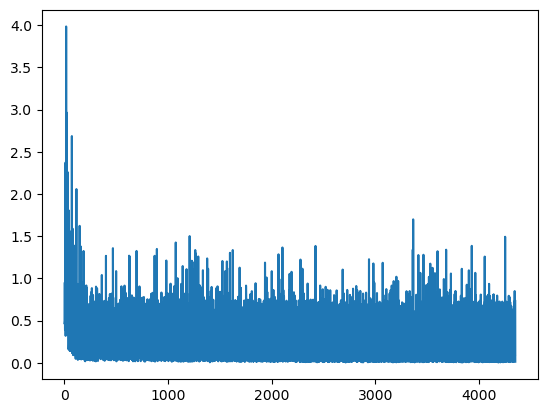

In [176]:
# want to see loss trending down
plt.plot(np.array(losses))

In [ ]:
# Next steps: 

# create delta for rest of input columns
# train test split 
# integrating all zipcodes - make dict of zipcodes and then handle zipcodes one by one